# Package Installation and Data Loading

In [ ]:
! pip3 install ripser

In [ ]:
! pip3 install giotto-tda

In [2]:
import pandas as pd
import numpy as np
import ripser
from persim import plot_diagrams
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.cluster import DBSCAN
import gudhi as gd
import math

## Construct Dataset and Set Filtration

In [3]:


# Create a dummy protein-protein interaction dataset

data = {
    'Protein1': ['A', 'A', 'B', 'B', 'C', 'D', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q'],
    'Protein2': ['B', 'C', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'A', 'B', 'C'],
    'Weight': [0.8, 0.6, 0.7, 0.9, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.6, 0.5, 0.7, 0.6, 0.9, 0.8, 0.5, 0.6, 0.7, 0.8]
}

ppi_df = pd.DataFrame(data)

# Create a dummy protein complex dataset
complexes = [['A', 'B', 'C'], ['D', 'E', 'F'], ['G', 'H', 'I', 'J'], ['K', 'L'], ['M', 'N', 'O'], ['P', 'Q']]


# Define the filtration parameter based on edge weights
filtration_parameter = 'Weight'


# Construct Network

In [4]:
import networkx as nx

# Create a graph from the PPI dataset
G = nx.Graph()
for index, row in ppi_df.iterrows():
    G.add_edge(row['Protein1'], row['Protein2'], weight=row['Weight'])

# Calculate persistent homology using Ripser
adj_mat_diags = ripser.ripser(nx.adjacency_matrix(G).toarray(), distance_matrix=False)['dgms']


/opt/homebrew/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


In [5]:
G.nodes

NodeView(('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q'))

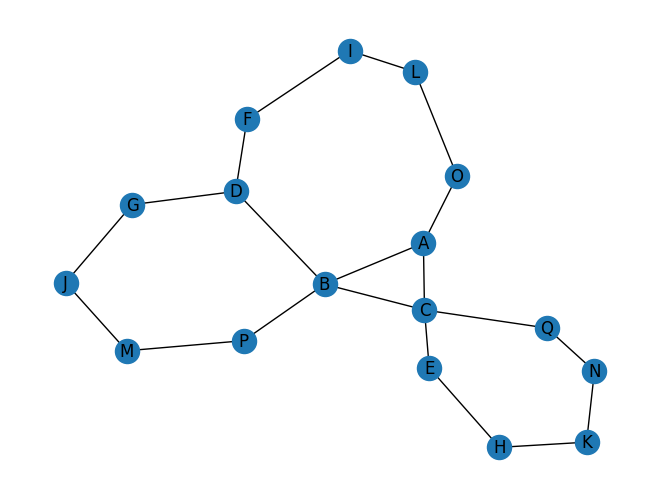

In [6]:
nx.draw_kamada_kawai(G, with_labels=True)

# Persistent Homology

## Vietoris Rips Filtration

In [116]:
## Using the distance to consider the network as a metric space takes away from the features that could be extracted from the edge weights
## we could see how this reflects on the persistence diagrams
D = np.array(nx.floyd_warshall_numpy(G))
D


array([[0. , 0.8, 0.6, 1.7, 1.1, 2.3, 2.4, 1.9, 2. , 3. , 2.5, 1.5, 2.3,
        1.9, 0.6, 1.5, 1.4],
       [0.8, 0. , 0.7, 0.9, 1.2, 1.5, 1.6, 2. , 2.4, 2.2, 2.6, 2.3, 1.5,
        2. , 1.4, 0.7, 1.5],
       [0.6, 0.7, 0. , 1.6, 0.5, 2.2, 2.3, 1.3, 2.6, 2.9, 1.9, 2.1, 2.2,
        1.3, 1.2, 1.4, 0.8],
       [1.7, 0.9, 1.6, 0. , 2.1, 0.6, 0.7, 2.9, 1.5, 1.5, 3.5, 2. , 2.2,
        2.9, 2.3, 1.6, 2.4],
       [1.1, 1.2, 0.5, 2.1, 0. , 2.7, 2.8, 0.8, 3.1, 3.4, 1.4, 2.6, 2.7,
        1.8, 1.7, 1.9, 1.3],
       [2.3, 1.5, 2.2, 0.6, 2.7, 0. , 1.3, 3.5, 0.9, 2.1, 4.1, 1.4, 2.8,
        3.5, 2.3, 2.2, 3. ],
       [2.4, 1.6, 2.3, 0.7, 2.8, 1.3, 0. , 3.6, 2.2, 0.8, 4.2, 2.7, 1.5,
        3.6, 3. , 2.3, 3.1],
       [1.9, 2. , 1.3, 2.9, 0.8, 3.5, 3.6, 0. , 3.9, 4.2, 0.6, 3.4, 3.5,
        1.2, 2.5, 2.7, 1.7],
       [2. , 2.4, 2.6, 1.5, 3.1, 0.9, 2.2, 3.9, 0. , 3. , 4.5, 0.5, 3.7,
        3.9, 1.4, 3.1, 3.4],
       [3. , 2.2, 2.9, 1.5, 3.4, 2.1, 0.8, 4.2, 3. , 0. , 4.8, 3.5, 0.7,
        4

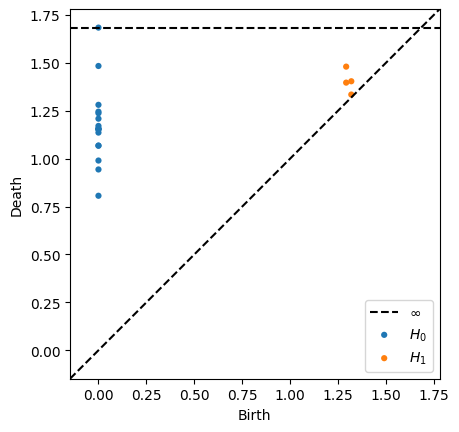

In [117]:
distance_mat_diags = ripser.ripser(D, distance_matrix=True)['dgms']
plot_diagrams(adj_mat_diags)

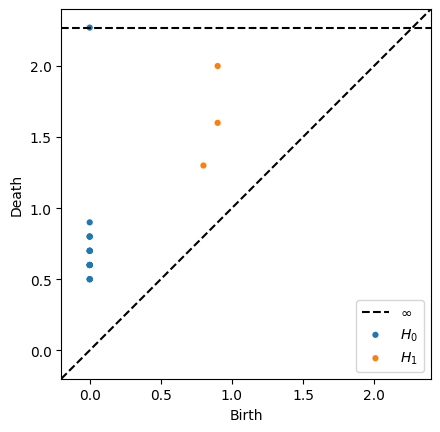

In [10]:
plot_diagrams(distance_mat_diags)

## Barcode Diagrams

In [4]:
def plot_barcode(diag, dim, **kwargs):
    #dim = 0
    diag_dim = diag[dim]
    birth = diag_dim[:, 0]; death = diag_dim[:, 1]
    finite_bars = death[death != np.inf]
    if len(finite_bars) > 0:
        inf_end = 2 * max(finite_bars)
    else:
        inf_end = 2
    death[death == np.inf] = inf_end
    plt.figure(figsize=kwargs.get('figsize', (10, 5)))
    for i, (b, d) in enumerate(zip(birth, death)):
        if d == inf_end:
            plt.plot([b, d], [i, i], color='k', lw=kwargs.get('linewidth', 2))
        else:
            plt.plot([b, d], [i, i], color=kwargs.get('color', 'b'), lw=kwargs.get('linewidth', 2))
    plt.title(kwargs.get('title', 'Persistence Barcode'))
    plt.xlabel(kwargs.get('xlabel', 'Filtration Value'))
    plt.yticks([])
    plt.tight_layout()
    plt.show()

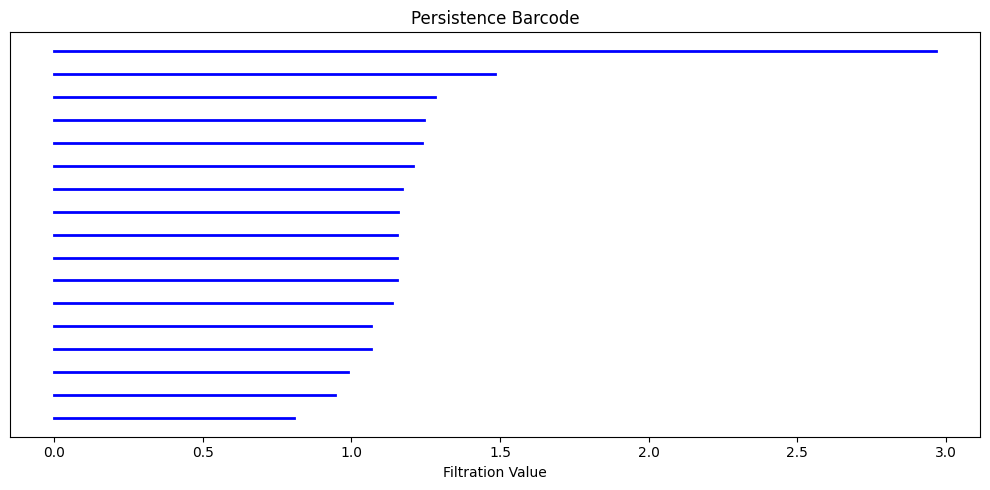

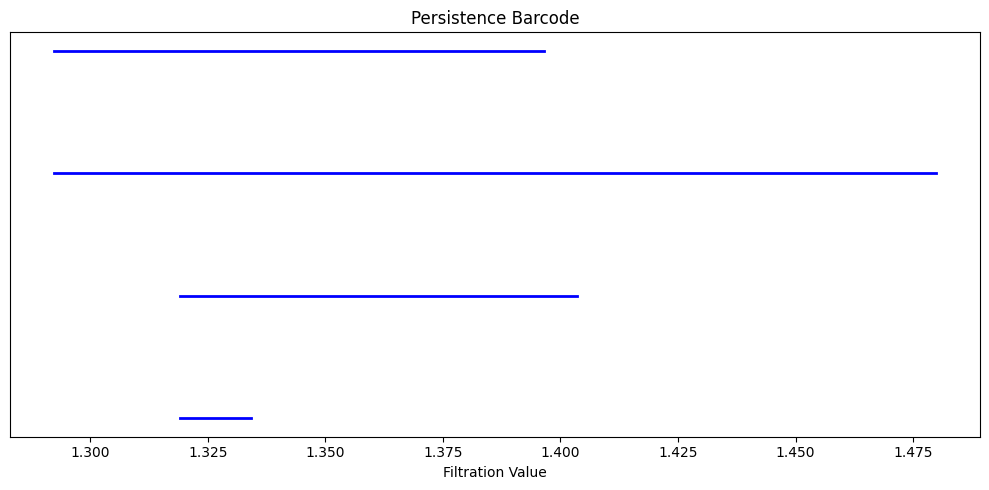

In [123]:
## The following are the barcode diagrams for the persistence diagrams extracted using the adjacency matrix fed into ripser (No distance)
## H_0
plot_barcode(adj_mat_diags, 0)
## H_1
plot_barcode(adj_mat_diags, 1)

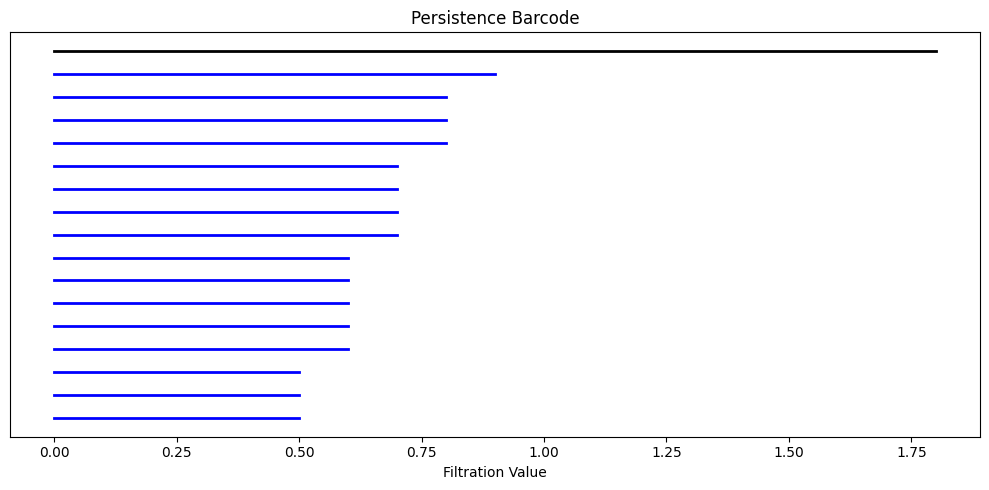

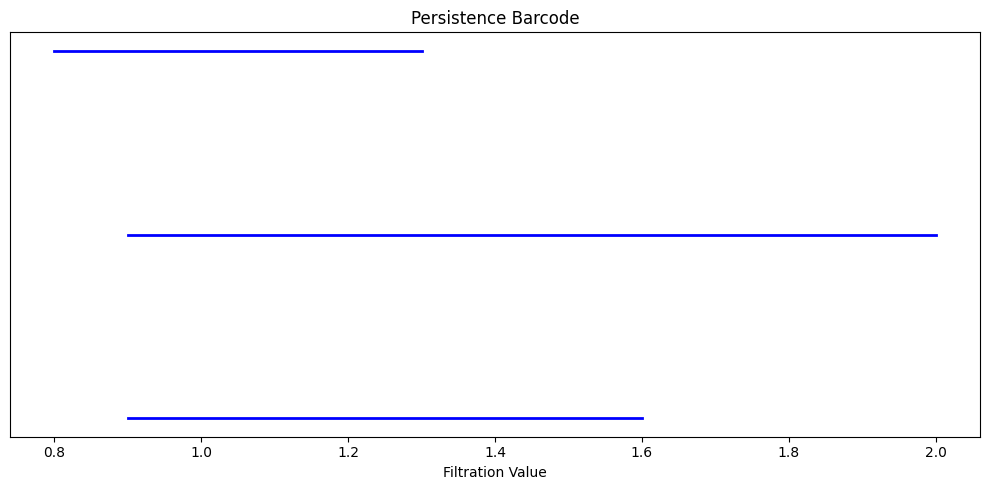

In [124]:
## The following are the barcode diagrams for the persistence diagrams extracted using the distance matrix for the dummy graph fed into ripser
## H_0
plot_barcode(distance_mat_diags, 0)
## H_1
plot_barcode(distance_mat_diags, 1)

## Betti Numbers

In [17]:
# Extract Betti numbers for each protein
betti_numbers = {}
for i, protein in enumerate(G.nodes):
    betti_numbers[i] = {
        'betti_0': 0,  # Initialize with 0 Betti_0
        'betti_1': 0   # Initialize with 0 Betti_1
    }

for h_i, dgm in enumerate(distance_mat_diags):
    for idx, pt in enumerate(dgm):
        if pt[1] != np.inf:
            if h_i == 0:
                betti_numbers[idx]['betti_0'] += 1
            elif h_i == 1:
                betti_numbers[idx]['betti_1'] += 1


In [14]:
for k, v in betti_numbers.items():
  print(k, v)

0 {'betti_0': 1, 'betti_1': 1}
1 {'betti_0': 1, 'betti_1': 1}
2 {'betti_0': 1, 'betti_1': 1}
3 {'betti_0': 1, 'betti_1': 0}
4 {'betti_0': 1, 'betti_1': 0}
5 {'betti_0': 1, 'betti_1': 0}
6 {'betti_0': 1, 'betti_1': 0}
7 {'betti_0': 1, 'betti_1': 0}
8 {'betti_0': 1, 'betti_1': 0}
9 {'betti_0': 1, 'betti_1': 0}
10 {'betti_0': 1, 'betti_1': 0}
11 {'betti_0': 1, 'betti_1': 0}
12 {'betti_0': 1, 'betti_1': 0}
13 {'betti_0': 1, 'betti_1': 0}
14 {'betti_0': 1, 'betti_1': 0}
15 {'betti_0': 1, 'betti_1': 0}
16 {'betti_0': 0, 'betti_1': 0}


## Clustering

In [2]:
# Extract features for clustering
feature_matrix = np.array([list(features.values()) for features in betti_numbers.values()])

# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=1, min_samples=1)
labels = dbscan.fit_predict(feature_matrix)

# Assign cluster labels to proteins
protein_labels = {protein: label for protein, label in zip(betti_numbers.keys(), labels)}


NameError: name 'np' is not defined

In [1]:
feature_matrix

NameError: name 'feature_matrix' is not defined

In [20]:
protein_labels

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0}

# Experimenting with Randomized Synthetic Network

## Creating a Randomized PPI Network 

In [31]:
## RANDOMIZED Network construction based on a given edge presence probability

# Initializing empty graph with the Networkx Package
protein_network = nx.Graph()

# Adding 100 proteins as nodes
proteins = [f"Protein_{i}" for i in range(1, 101)]
protein_network.add_nodes_from(proteins)

# Adding some randomization by assigning a probability parameter for edge creation
edge_probability = 0.15  

# Assigning random weights to edges with given probability
for i, protein1 in enumerate(proteins):
    for j, protein2 in enumerate(proteins):
        if i < j and random.random() < edge_probability:  # Ensuring to add only one side of the edge to avoid duplicates and self-loops
            # Assigning random weights for edges
            protein_network.add_edge(protein1, protein2, weight=random.uniform(0, 1.0))


In [32]:
# Creating protein complexes (connecting nodes within complexes with higher weights)
complex_1 = random.sample(proteins, 10)
complex_2 = random.sample(proteins, 7)
complex_3 = random.sample(proteins, 5)

# Assigning higher weights to edges between proteins that belong in the complexes
for complex_proteins in [complex_1, complex_2, complex_3]:
    for i in range(len(complex_proteins)):
        for j in range(i+1, len(complex_proteins)):
            if protein_network.has_edge(complex_proteins[i], complex_proteins[j]):
                ## For each protein belonging to a complex double the edge weight to indicate stronger interaction
                protein_network[complex_proteins[i]][complex_proteins[j]]['weight'] *= 2  

## Let's see how the network edges look like
for edge in protein_network.edges(data=True):
    print(edge)

('Protein_1', 'Protein_14', {'weight': 0.2521354857149388})
('Protein_1', 'Protein_16', {'weight': 0.012204711487427966})
('Protein_1', 'Protein_20', {'weight': 0.6468818102027569})
('Protein_1', 'Protein_32', {'weight': 0.05684032690030949})
('Protein_1', 'Protein_34', {'weight': 0.3690679224985599})
('Protein_1', 'Protein_44', {'weight': 0.5853576757756009})
('Protein_1', 'Protein_56', {'weight': 0.20585273834173812})
('Protein_1', 'Protein_58', {'weight': 0.6897778951504359})
('Protein_1', 'Protein_62', {'weight': 0.4313908436855566})
('Protein_1', 'Protein_76', {'weight': 0.47528857204175357})
('Protein_1', 'Protein_82', {'weight': 0.7272310232852185})
('Protein_1', 'Protein_86', {'weight': 0.06405777640906807})
('Protein_1', 'Protein_98', {'weight': 0.6083264118197234})
('Protein_2', 'Protein_13', {'weight': 0.03705194783767973})
('Protein_2', 'Protein_30', {'weight': 0.06563657438786219})
('Protein_2', 'Protein_32', {'weight': 0.5913858614598616})
('Protein_2', 'Protein_33', {'we

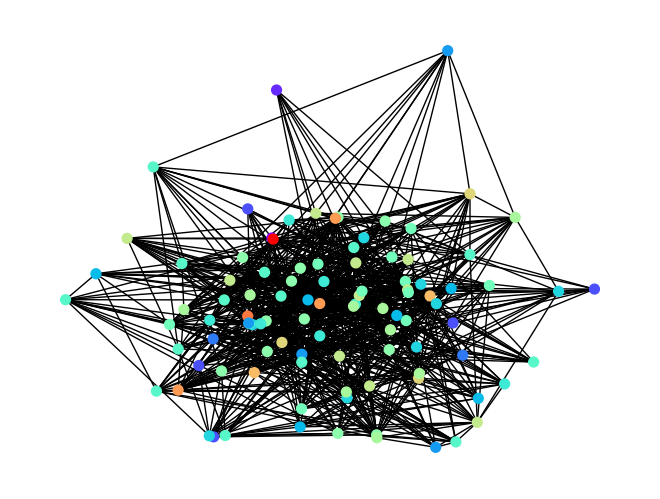

In [33]:
scaled_degree = [d[1]*50 for d in nx.degree(protein_network)]
nx.draw_kamada_kawai(protein_network,
        # Weights Based on Column
        width=list(nx.get_edge_attributes(protein_network, 'SemSim').values()),
        # Node size based on degree
        node_size=50,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

In [34]:
protein_network.degree

DegreeView({'Protein_1': 13, 'Protein_2': 15, 'Protein_3': 12, 'Protein_4': 17, 'Protein_5': 14, 'Protein_6': 12, 'Protein_7': 9, 'Protein_8': 16, 'Protein_9': 20, 'Protein_10': 14, 'Protein_11': 18, 'Protein_12': 17, 'Protein_13': 17, 'Protein_14': 17, 'Protein_15': 13, 'Protein_16': 18, 'Protein_17': 18, 'Protein_18': 21, 'Protein_19': 12, 'Protein_20': 10, 'Protein_21': 20, 'Protein_22': 15, 'Protein_23': 16, 'Protein_24': 7, 'Protein_25': 11, 'Protein_26': 17, 'Protein_27': 15, 'Protein_28': 15, 'Protein_29': 14, 'Protein_30': 17, 'Protein_31': 17, 'Protein_32': 19, 'Protein_33': 18, 'Protein_34': 17, 'Protein_35': 9, 'Protein_36': 19, 'Protein_37': 16, 'Protein_38': 18, 'Protein_39': 19, 'Protein_40': 16, 'Protein_41': 14, 'Protein_42': 15, 'Protein_43': 15, 'Protein_44': 26, 'Protein_45': 18, 'Protein_46': 13, 'Protein_47': 16, 'Protein_48': 13, 'Protein_49': 9, 'Protein_50': 11, 'Protein_51': 17, 'Protein_52': 22, 'Protein_53': 17, 'Protein_54': 9, 'Protein_55': 18, 'Protein_56'

## Applying Persistent Homology (Rips Persistence)

In [35]:
pn_adjacency = nx.adjacency_matrix(protein_network).toarray()

/opt/homebrew/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


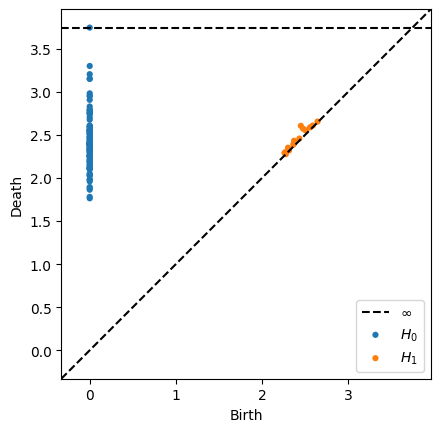

In [36]:
pn_diagrams = ripser.ripser(pn_adjacency, distance_matrix=False)['dgms']
plot_diagrams(pn_diagrams)

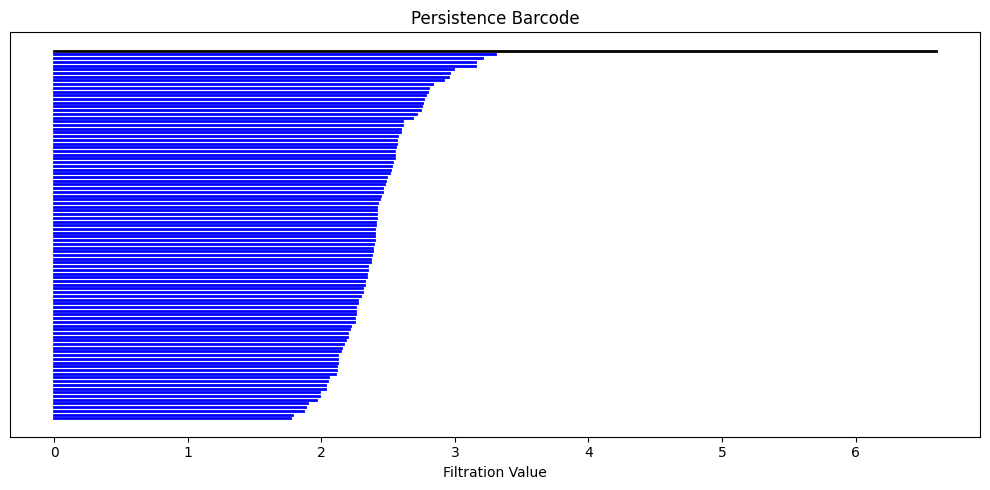

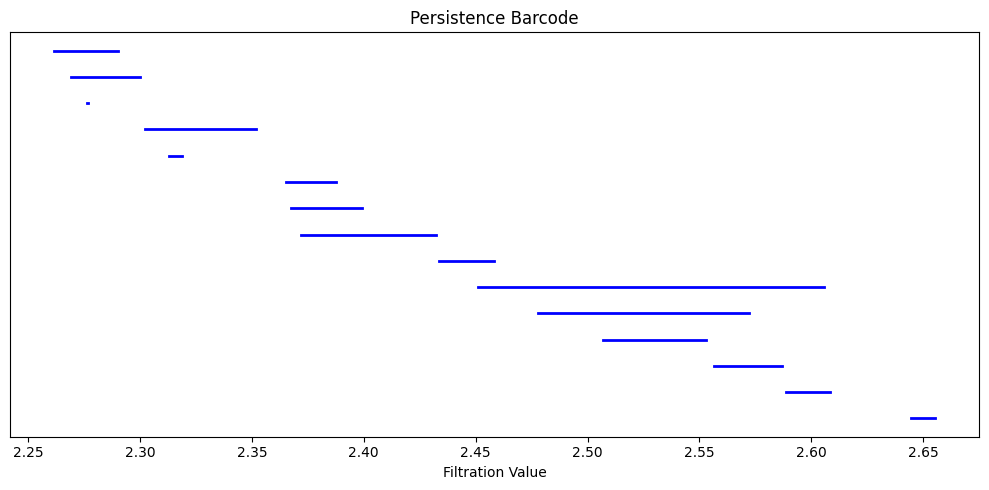

In [37]:
## Exploring the Barcode Diagrams for the two Homology ranks 0 and 1
## H_0
plot_barcode(pn_diagrams, 0)
## H_1  
plot_barcode(pn_diagrams, 1)

## Analysis and Clustering

In [38]:
## Let's store the proteins in an indexed dictionary so we could track them back when building the simplex tree
proteins_dict = {protein: idx for idx, protein in enumerate(proteins)}

In [39]:
# Given protein-protein interaction network we can start by creating a simplex tree that includes all 0-simplices (nodes)

# Construct a simplex tree from the network
simplex_tree = gd.SimplexTree()

for edge in protein_network.edges(data=True):
    node1, node2, weight = edge
    ## Get protein index from dict to map it back and feed it into the simplex tree
    node1_idx = proteins_dict[node1]
    node2_idx = proteins_dict[node2]
    simplex_tree.insert([node1_idx, node2_idx], filtration=weight['weight'])



In [13]:
## TESTING
simplex_tree

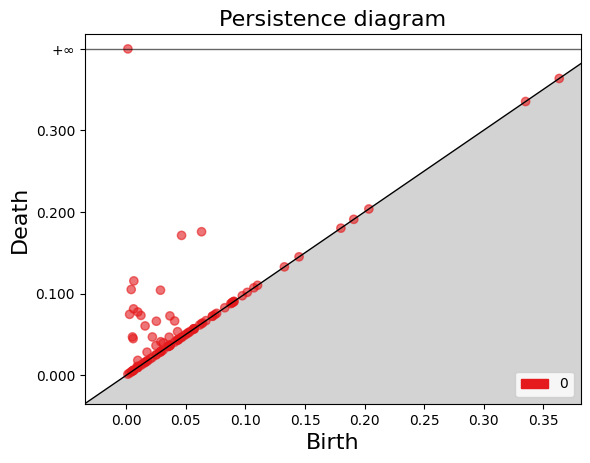

In [40]:
# Compute persistence diagrams
## NOTE: min_persistence is set to -1 to view all the simplex values (Include all 0-simplices)

persistence = simplex_tree.persistence(min_persistence=-1, persistence_dim_max=False)

# Generate persistence diagrams
diagrams = gd.plot_persistence_diagram(persistence)

In [206]:
len(persistence)

970

In [41]:
## death values of np.inf would not give us a measure to cluster them with DBSCAN, so let's set a cap death time for those to a max value of 1
for i, pt in enumerate(persistence):
    if pt[1][1] == np.inf:
        pt = list(pt)
        pt[1] = list(pt[1])
        pt[1][1] = 1
        pt[1] = tuple(pt[1])
        persistence[i] = tuple(pt)
        #print(pt)

In [44]:

# Extract features from the persistence diagrams
# I will use just the birth and death times of the topological features for now and see how DBSCAN would perfrom in the clustering
features = np.array([[pt[1][0], pt[1][1]] for pt in persistence])


# Cluster the proteins into complexes using DBSCAN
dbscan = DBSCAN(eps=0.005, min_samples=3)
dbscan.fit(features)

# Get the predicted labels (complexes)
predicted_labels = dbscan.labels_


In [45]:
## TESTING 
predicted_labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,
        1,  1,  1,  0,  1,  0,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,  0,
        1,  1,  1,  0,  1,  1,  1,  1,  1,  0,  2,  2,  2,  0,  0,  2,  3,
        3,  0,  0,  3,  0,  3,  0,  0, -1,  4,  4,  4,  4,  4,  4, -1, -1,
        0,  0, -1, -1,  0, -1, -1,  0,  0, -1, -1, -1, -1, -1,  1])

In [46]:
# Print predicted complexes
complexes = {}
for i, protein in enumerate(proteins):
    label = predicted_labels[i]
    if label not in complexes:
        complexes[label] = []
    complexes[label].append(protein)

print("Predicted complexes:")
for label, members in complexes.items():
    print(f"Complex {label}: {', '.join(members)}")

Predicted complexes:
Complex -1: Protein_1, Protein_2, Protein_3, Protein_4, Protein_5, Protein_6, Protein_7, Protein_8, Protein_9, Protein_10, Protein_11, Protein_12, Protein_13, Protein_14, Protein_15, Protein_16, Protein_17, Protein_18, Protein_19, Protein_20, Protein_21, Protein_22, Protein_23, Protein_24, Protein_77, Protein_84, Protein_85, Protein_88, Protein_89, Protein_91, Protein_92, Protein_95, Protein_96, Protein_97, Protein_98, Protein_99
Complex 0: Protein_25, Protein_26, Protein_27, Protein_28, Protein_29, Protein_34, Protein_38, Protein_40, Protein_45, Protein_48, Protein_49, Protein_50, Protein_51, Protein_55, Protein_61, Protein_65, Protein_66, Protein_70, Protein_71, Protein_73, Protein_75, Protein_76, Protein_86, Protein_87, Protein_90, Protein_93, Protein_94
Complex 1: Protein_30, Protein_31, Protein_32, Protein_33, Protein_35, Protein_36, Protein_37, Protein_39, Protein_41, Protein_42, Protein_43, Protein_44, Protein_46, Protein_47, Protein_52, Protein_53, Protein_

In [213]:
print(len(complex_1))
complex_1

10


['Protein_14',
 'Protein_52',
 'Protein_19',
 'Protein_89',
 'Protein_83',
 'Protein_25',
 'Protein_72',
 'Protein_62',
 'Protein_10',
 'Protein_67']

In [214]:
print(len(complex_2))
complex_2

7


['Protein_26',
 'Protein_18',
 'Protein_29',
 'Protein_89',
 'Protein_9',
 'Protein_88',
 'Protein_68']

In [215]:
print(len(complex_3))
complex_3

5


['Protein_22', 'Protein_90', 'Protein_55', 'Protein_80', 'Protein_85']

## DBSCAN Parameter Estimation

In [21]:
x = []
for pt in persistence:
    x.append(list(pt[1]))
x

[[0.0007365693472144441, 1],
 [0.028455017556695883, 0.11484445978925606],
 [0.0011172759677245958, 0.07476843422210444],
 [0.006722602264062072, 0.0796654736208271],
 [0.009966167105075807, 0.08004768215282632],
 [0.016043028565027595, 0.08170192294737755],
 [0.0051999109190647985, 0.07053314776759145],
 [0.06930852566393075, 0.12644265939066202],
 [0.035237554693390294, 0.08935900503256877],
 [0.04019359139141143, 0.09281164649825935],
 [0.008311844815596992, 0.05811507052225218],
 [0.0032978415254322213, 0.05294529203097109],
 [0.01681083621912416, 0.06636590326318281],
 [0.010750254343195431, 0.049047409165477895],
 [0.004625079620695027, 0.03126094536233781],
 [0.006121188079095119, 0.02869014584945373],
 [0.021360326722009382, 0.041086509762823686],
 [0.03997650008671749, 0.05577407340881502],
 [0.043900495517880556, 0.0571056002857151],
 [0.08210798529118257, 0.09505182218285524],
 [0.08789718777903621, 0.09803959081567071],
 [0.12107485205798918, 0.1296028098906412],
 [0.057658

In [19]:
# Calculate k-nearest neighbors epsilon-distances 
def calculate_kn_distance(X,k):
    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i][0] - X[j][0]) ** 2) +
                    ((X[i][1] - X[j][1]) ** 2)))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

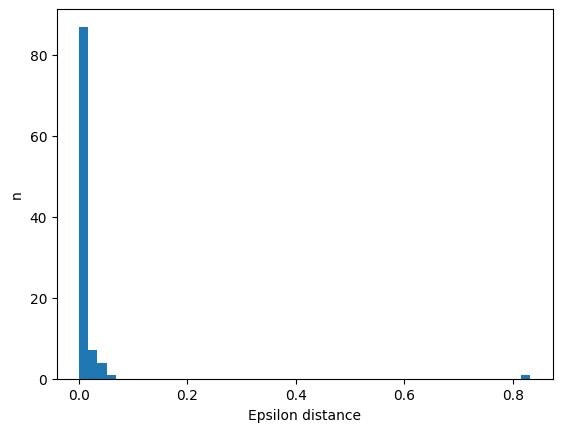

In [24]:
## Plot eps_distances
eps_dist = calculate_kn_distance(x,3)
plt.hist(eps_dist,bins=50)
plt.ylabel('n');
plt.xlabel('Epsilon distance');
